In [20]:
#pip install numpy 

In [21]:
#pip install scikit-learn

In [22]:
#pip install matplotlib

In [23]:
#pip install seaborn 

In [24]:
#pip install statsmodels

In [25]:
#pip install xgboost

In [26]:
#pip install darts

In [27]:
#pip install mlflow


In [28]:
#pip install pyngrok --quiet

In [29]:
#pip uninstall -y tensorflow tensorflow-intel tensorflow-io-gcs-filesystem ml-dtypes protobuf grpcio

In [30]:
#pip install tensorflow==2.16.1

# Bibliotheken laden

In [31]:
# Bibliotheken importieren

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBModel

import mlflow
import mlflow.xgboost

from pyngrok import ngrok, conf
import getpass
import subprocess

import os

# reproducibility
np.random.seed(42)

#from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV # new import we need for this week

In [32]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping



tf.random.set_seed(42)


In [33]:
# Speicherort für MLflow Runs (lokal auf deinem Mac)
mlflow_storage_path = "/Users/laurapeters/Desktop/VS-Time-series-Projekt/mlflow_results"
os.makedirs(mlflow_storage_path, exist_ok=True)

# Tracking konfigurieren
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

# Experiment festlegen (wird automatisch erstellt, falls nicht vorhanden)
mlflow.set_experiment("Modell-Vergleiche")

<Experiment: artifact_location='file:///Users/laurapeters/Desktop/VS-Time-series-Projekt/mlflow_results/551520531669055046', creation_time=1756999473550, experiment_id='551520531669055046', last_update_time=1756999473550, lifecycle_stage='active', name='Modell-Vergleiche', tags={}>

# Daten laden

In [34]:
# Define the MLflow storage path in Google Drive
mlflow_storage_path = "./files/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [35]:
# Set up experiment name
mlflow.set_experiment("XGB_vs_XGB_Hyperparam")   # creates it once, reuses it next time

<Experiment: artifact_location='file:///Users/laurapeters/Desktop/VS-Time-series-Projekt/notebooks/files/mlflow_results/823126783632742089', creation_time=1757000087169, experiment_id='823126783632742089', last_update_time=1757000087169, lifecycle_stage='active', name='XGB_vs_XGB_Hyperparam', tags={}>

# Start MLFlow UI

In [36]:
# Launch MLflow UI on port 5000
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', './fi...>

In [37]:
'''print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = "32CUtezl2L77vuYQQo6Gqt9M5ih_3KPUDPugApg6QPqySKF18"
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel (ULR for MLFLow UI) \"{public_url}\" ')'''

'print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")\nconf.get_default().auth_token = "32CUtezl2L77vuYQQo6Gqt9M5ih_3KPUDPugApg6QPqySKF18"\nport=5000\npublic_url = ngrok.connect(port).public_url\nprint(f\' * ngrok tunnel (ULR for MLFLow UI) "{public_url}" \')'

In [38]:
df_train_ML_ready = pd.read_parquet("/Users/laurapeters/Desktop/VS-Time-series-Projekt/files/df_train_ML_ready.parquet")

# Optional: kurz prüfen
print(df_train_ML_ready.head())

        date        id  store_nbr  item_nbr  unit_sales  onpromotion  \
0 2014-02-21  19281571         24    103520         2.0        False   
1 2014-02-22  19331514         24    103520         8.0        False   
2 2014-02-23  19382503         24    103520         3.0        False   
3 2014-02-24  19432532         24    103520         1.0        False   
4 2014-02-25  19481433         24    103520         6.0        False   

   is_outlier  year  month  day  ...  holiday_transferred transactions  lag_7  \
0       False  2014      2   21  ...                    0       2455.0   10.0   
1       False  2014      2   22  ...                    0       2291.0   10.0   
2       False  2014      2   23  ...                    0       1419.0    8.0   
3       False  2014      2   24  ...                    0       2247.0    4.0   
4       False  2014      2   25  ...                    0       2192.0    2.0   

   lag_30  lag_364 rolling_7d_std rolling_30d_std rolling_7d_mean  \
0     3.0  

# Target // Features definieren

In [39]:
max_date = '2015-01-01'
df_train_ML_ready = df_train_ML_ready[(df_train_ML_ready['date'] < max_date)]

split_date = '2014-10-01'
train = df_train_ML_ready[df_train_ML_ready['date'] < split_date]
test = df_train_ML_ready[df_train_ML_ready['date'] > split_date]


ERROR:    [Errno 48] Address already in use


Running the mlflow server failed. Please see the logs above for details.


In [40]:
# Define target variable (unit_sales) and features
X = df_train_ML_ready[['onpromotion',
       'is_outlier', 'year', 'month', 'day', 'day_of_week', 'family',
       'item_class', 'dcoilwtico', 'city', 'state', 'store_type',
       'sim_store_cluster', 'holiday_type', 'holiday_transferred',
       'transactions', 'lag_7', 'lag_30', 'lag_364',
       'rolling_7d_std', 'rolling_30d_std', 'rolling_7d_mean',
       'rolling_30d_mean', 'is_weekend']]
y = df_train_ML_ready['unit_sales']



# Train Test Split

In [41]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Train:", X_train.shape, y_train.shape)
print("Test:",  X_test.shape, y_test.shape)


Train: (983860, 24) (983860,)
Test: (245965, 24) (245965,)


# Encoding

## One Hot Encoding

In [42]:
# Kategoriale Spalten
X_cat = ['city', 'state', 'store_type', 'sim_store_cluster', 
         'holiday_type', 'holiday_transferred', 'family']

for col in X_cat:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    
# Encoder initialisieren
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit + Transform auf Trainingsdaten
X_train_ohe = pd.DataFrame(
    ohe.fit_transform(X_train[X_cat]),
    columns=ohe.get_feature_names_out(X_cat),
    index=X_train.index
)

# Alte Spalten entfernen und OHE-Spalten anhängen
X_train = pd.concat([X_train.drop(columns=X_cat), X_train_ohe], axis=1)


In [43]:
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[X_cat]),  # Achtung: transform, nicht fit_transform
    columns=ohe.get_feature_names_out(X_cat),
    index=X_test.index
)

X_test = pd.concat([X_test.drop(columns=X_cat), X_test_ohe], axis=1)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Min/Max-Scaler 

In [44]:
X_num = ['dcoilwtico','transactions',  'lag_7', 'lag_30', 'lag_364', 'rolling_7d_std',
         'rolling_30d_std', 'rolling_7d_mean', 'rolling_30d_mean']

scaler = MinMaxScaler()

X_train[X_num] = scaler.fit_transform(X_train[X_num])

In [45]:
X_test[X_num] = scaler.transform(X_test[X_num])


In [46]:
'''
# Training
y_train_log = np.log1p(y_train)  # log(1 + y)
final_model.fit(X_train, y_train_log)

# Vorhersage
y_pred_log = final_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Rücktransformation
'''

'\n# Training\ny_train_log = np.log1p(y_train)  # log(1 + y)\nfinal_model.fit(X_train, y_train_log)\n\n# Vorhersage\ny_pred_log = final_model.predict(X_test)\ny_pred = np.expm1(y_pred_log)  # Rücktransformation\n'

In [47]:
bool_cols = X_train.select_dtypes(include='bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# y log-Transformieren

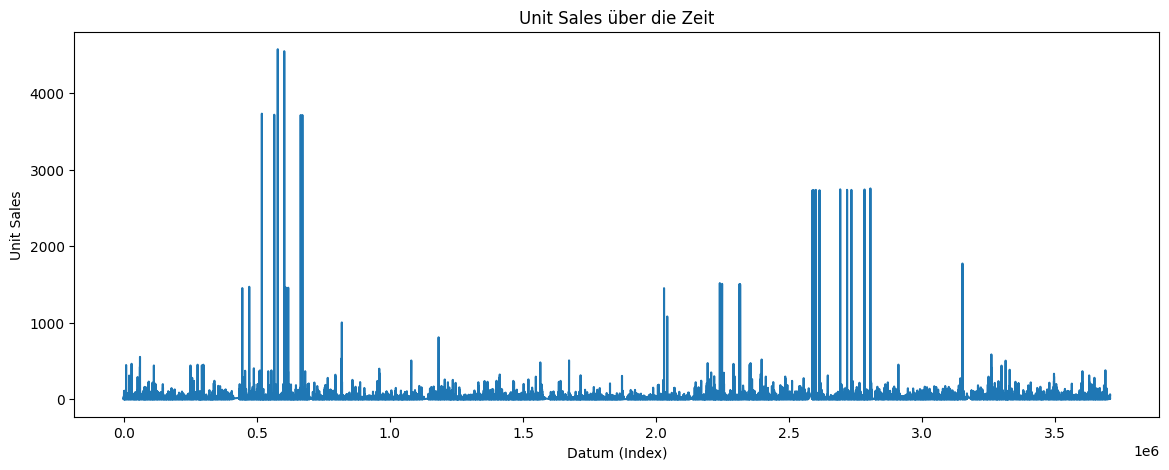

In [48]:
plt.figure(figsize=(14,5))
plt.plot(df_train_ML_ready.index, df_train_ML_ready['unit_sales'])
plt.title('Unit Sales über die Zeit')
plt.xlabel('Datum (Index)')
plt.ylabel('Unit Sales')
plt.show()

In [49]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [50]:
y_test_log.isnull().sum()

0

In [51]:
#Lets compare the metrics we studied in this lecture. We will include MAE as its the one we already saw
# MAE, Bias, Mean Absolute Deviation (MAD), Relative Mean Absolute Deviation (rMAD), Mean absolute percentage error (MAPE), Root Mean Square Error (RMSE).
import numpy as np

def forecast_metrics(y_true, y_pred):
    """
    Compute a common set of forecast-error statistics.

    Parameters
    ----------
    y_true : 1-D array-like
        Actual (ground-truth) values.
    y_pred : 1-D array-like
        Forecasted values.

    Returns
    -------
    dict
        Keys: 'MAE', 'Bias', 'MAD', 'rMAD', 'MAPE', 'RMSE'
    """
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }


In [52]:
# ---- quick plot saver
def save_forecast_plot(y_true, y_pred, path, title="Forecast vs Actual"):
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label="Actual", lw=2)
    plt.plot(y_pred, label="Predicted", lw=2)
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.savefig(path); plt.close()

# ---- one-stop logger for a single candidate
def log_candidate(run_name, params, y_true, y_pred, fig_name, model=None):
    with mlflow.start_run(run_name=run_name, nested=True):
        mlflow.log_params(params)
        mlflow.log_metrics(forecast_metrics(y_true, y_pred))
        save_forecast_plot(y_true, y_pred, fig_name, title=run_name)
        mlflow.log_artifact(fig_name)

        if model is None:
            return
        elif isinstance(model, XGBModel):  # covers XGBRegressor/Classifier
            mlflow.xgboost.log_model(model, name="model")
        else:
            # fallback: skip or raise
            pass

# LSTM

/var/folders/kc/4_58vml5169c4h_nkcgknsy80000gn/T/ipykernel_19855/3766675945.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_lstm = df_lstm.fillna(method='ffill').fillna(0)


Data shape: (1229825, 18)
Train samples: 983860, Test samples: 245965
Scaled train shape: (983860, 18)
Scaled test shape: (245965, 18)
X_train shape: (983845, 15, 18)
y_train shape: (983845,)
X_test shape: (245950, 15, 18)
y_test shape: (245950,)
Number of features: 18


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,073 (27.63 KB)

 Trainable params: 7,073 (27.63 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM...
Epoch 1/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 9.2125e-05 - mae: 0.0031 - val_loss: 7.1687e-06 - val_mae: 0.0014
Epoch 2/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 1.3908e-05 - mae: 0.0011 - val_loss: 6.6676e-06 - val_mae: 0.0013
Epoch 3/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - loss: 1.3721e-05 - mae: 0.0011 - val_loss: 6.5001e-06 - val_mae: 0.0013
Epoch 4/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 1.3587e-05 - mae: 0.0010 - val_loss: 6.4664e-06 - val_mae: 0.0013
Epoch 5/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 1.3482e-05 - mae: 0.0010 - val_loss: 6.3878e-06 - val_mae: 0.0013
Epoch 6/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 1.3383e-05 - mae: 0.0010 - val_loss: 6.3507e-06 - val_mae: 0.0013
Epoch 7/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 1.3359e-05 - mae: 0.0010 - val_loss: 6.3187e-06 - val_mae: 0.0013
Epoch 8/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 1

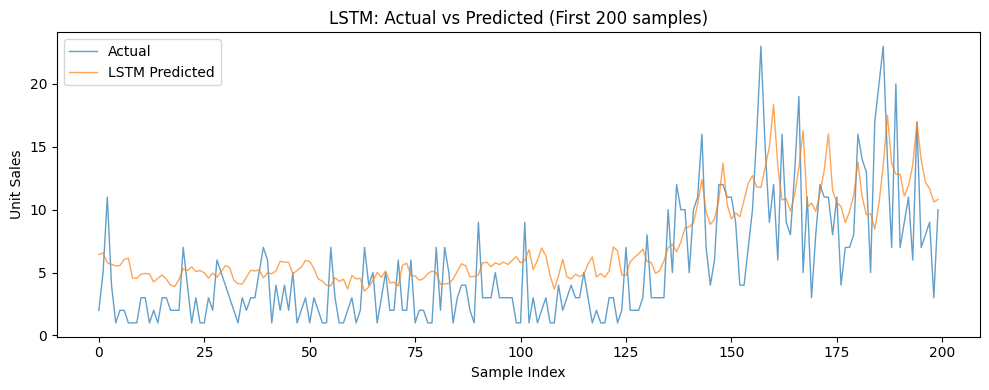


LSTM Training completed!
Sequence Length: 15
Features used: 18


In [53]:
# Nur numerische Spalten für LSTM verwenden (kategoriale sind schwierig für sequences)
numerical_cols = [
    'unit_sales', 'onpromotion', 'is_outlier', 'year', 'month', 'day', 
    'day_of_week', 'item_class', 'dcoilwtico', 'transactions', 
    'lag_7', 'lag_30', 'lag_364', 'rolling_7d_std', 'rolling_30d_std',
    'rolling_7d_mean', 'rolling_30d_mean', 'is_weekend'
]

# Daten sortieren nach Datum (wichtig für Zeitreihen!)
df_lstm = df_train_ML_ready[numerical_cols].copy()
df_lstm = df_lstm.sort_index()  # Annahme: Index ist bereits das Datum

# NaN-Werte füllen
df_lstm = df_lstm.fillna(method='ffill').fillna(0)

values = df_lstm.values
print(f"Data shape: {values.shape}")

# Calendar split and scaling
cut = int(len(values) * 0.8)
print(f"Train samples: {cut}, Test samples: {len(values) - cut}")

# Scaler nur auf Training-Daten fitten
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(values[:cut])
test_scaled = scaler.transform(values[cut:])

print(f"Scaled train shape: {train_scaled.shape}")
print(f"Scaled test shape: {test_scaled.shape}")

# Make sliding windows - ANGEPASST
SEQ_LEN = 15  # Kürzer für schnelleres Training
TARGET_COL = 0  # unit_sales ist die erste Spalte

def make_sequences(arr, seq_len, target_col=0):
    """Erstellt Sequenzen für LSTM"""
    X, y = [], []
    for i in range(len(arr) - seq_len):
        # X: seq_len Zeitschritte mit allen Features
        X.append(arr[i : i + seq_len, :])  
        # y: nächster unit_sales Wert
        y.append(arr[i + seq_len, target_col])  
    return np.array(X), np.array(y)

# Sequenzen erstellen
X_train, y_train = make_sequences(train_scaled, SEQ_LEN, TARGET_COL)
X_test, y_test = make_sequences(test_scaled, SEQ_LEN, TARGET_COL)

print(f"X_train shape: {X_train.shape}")  # (samples, seq_len, features)
print(f"y_train shape: {y_train.shape}")  # (samples,)
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Build LSTM Model - VEREINFACHT für Speed
def build_quick_lstm(seq_len, n_features):
    """Schnelles, einfaches LSTM"""
    model = Sequential([
        LSTM(32, return_sequences=False, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        Dense(16),
        Dropout(0.1),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Model erstellen
n_features = X_train.shape[2]
print(f"Number of features: {n_features}")

model = build_quick_lstm(SEQ_LEN, n_features)
model.summary()

# Training - MIT Early Stopping für Speed
print("Training LSTM...")

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,  # Weniger Epochen für Speed
    batch_size=64,  # Größere Batches für Speed
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Predictions & Evaluation
print("Making predictions...")

# Vorhersagen
train_pred = model.predict(X_train, batch_size=64)
test_pred = model.predict(X_test, batch_size=64)

# Rücktransformation der Vorhersagen
# Dummy array für inverse transform (scaler braucht alle Features)
def inverse_scale_target(scaled_values, original_scaler, target_col=0):
    """Rücktransformation nur für Target-Variable"""
    dummy = np.zeros((len(scaled_values), original_scaler.n_features_in_))
    dummy[:, target_col] = scaled_values.flatten()
    inversed = original_scaler.inverse_transform(dummy)
    return inversed[:, target_col]

# Rücktransformation
y_train_orig = inverse_scale_target(y_train.reshape(-1, 1), scaler, TARGET_COL)
y_test_orig = inverse_scale_target(y_test.reshape(-1, 1), scaler, TARGET_COL)
train_pred_orig = inverse_scale_target(train_pred, scaler, TARGET_COL)
test_pred_orig = inverse_scale_target(test_pred, scaler, TARGET_COL)

# Metriken berechnen
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_mae = mean_absolute_error(y_train_orig, train_pred_orig)
test_mae = mean_absolute_error(y_test_orig, test_pred_orig)
train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_pred_orig))
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_pred_orig))

print(f"\n=== LSTM Results ===")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Quick Plot - nur erste 200 samples
n_plot = min(200, len(y_test_orig))
plt.figure(figsize=(10, 4))
plt.plot(y_test_orig[:n_plot], label='Actual', alpha=0.7, linewidth=1)
plt.plot(test_pred_orig[:n_plot], label='LSTM Predicted', alpha=0.7, linewidth=1)
plt.title(f'LSTM: Actual vs Predicted (First {n_plot} samples)')
plt.xlabel('Sample Index')
plt.ylabel('Unit Sales')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nLSTM Training completed!")
print(f"Sequence Length: {SEQ_LEN}")
print(f"Features used: {n_features}")

In [54]:
# Unterordner für Plots erstellen
os.makedirs("plots", exist_ok=True)

# Zusatzmetriken definieren
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

with mlflow.start_run(run_name="LSTM_12Months"):

    # Hyperparameter definieren
    lstm_params = {
        "units": 32,
        "dropout": 0.2,
        "epochs": 20,
        "batch_size": 64,
        "learning_rate": 0.001
    }
    mlflow.log_params(lstm_params)
    mlflow.log_param("model_type", "LSTM")

    # LSTM Modell erstellen und compile
    model = Sequential([
        LSTM(lstm_params["units"], return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(lstm_params["dropout"]),
        Dense(16),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # EarlyStopping Callback
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Training
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=lstm_params["epochs"],
        batch_size=lstm_params["batch_size"],
        callbacks=[early_stop],
        verbose=1
    )

    # Vorhersage auf Testdaten
    test_pred = model.predict(X_test, batch_size=lstm_params["batch_size"])

    # Rücktransformation der Vorhersage
    def inverse_scale_target(scaled_values, original_scaler, target_col=0):
        dummy = np.zeros((len(scaled_values), original_scaler.n_features_in_))
        dummy[:, target_col] = scaled_values.flatten()
        inversed = original_scaler.inverse_transform(dummy)
        return inversed[:, target_col]

    y_test_orig = inverse_scale_target(y_test.reshape(-1,1), scaler, target_col=0)
    test_pred_orig = inverse_scale_target(test_pred, scaler, target_col=0)

    # Metriken berechnen
    mae = mean_absolute_error(y_test_orig, test_pred_orig)
    mse = mean_squared_error(y_test_orig, test_pred_orig)
    rmse = np.sqrt(mse)
    smape_val = smape(y_test_orig, test_pred_orig)
    wmape_val = wmape(y_test_orig, test_pred_orig)

    # Metriken loggen
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("SMAPE", smape_val)
    mlflow.log_metric("wMAPE", wmape_val)

    # Plot erstellen, speichern & loggen
    plt.figure(figsize=(14,7))
    plt.plot(y_test_orig[:200], label="Actual")
    plt.plot(test_pred_orig[:200], label="Predicted", color="red")
    plt.title("Actual vs Predicted Sales – LSTM 12 Months")
    plt.legend()
    plt.tight_layout()
    plot_file = os.path.join("plots", "forecast_LSTM_12Months.png")
    plt.savefig(plot_file)
    plt.close()

    # Alle Plots aus dem Ordner 'plots' loggen
    mlflow.log_artifacts("plots", artifact_path="plots")

    # Keras Modell speichern
    mlflow.keras.log_model(model, artifact_path="model")

print(
    f"LSTM 12 Months Run abgeschlossen – "
    f"MAE={mae:.2f}, RMSE={rmse:.2f}, SMAPE={smape_val:.2f}%, wMAPE={wmape_val:.2f}%"
)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 1.3408e-04 - mae: 0.0036 - val_loss: 6.8376e-06 - val_mae: 0.0013
Epoch 2/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - loss: 1.3892e-05 - mae: 0.0011 - val_loss: 6.7164e-06 - val_mae: 0.0014
Epoch 3/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 1.3714e-05 - mae: 0.0011 - val_loss: 6.5011e-06 - val_mae: 0.0013
Epoch 4/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 1.3584e-05 - mae: 0.0010 - val_loss: 6.4015e-06 - val_mae: 0.0013
Epoch 5/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1.3468e-05 - mae: 0.0010 - val_loss: 6.2943e-06 - val_mae: 0.0012
Epoch 6/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 1.3399e-05 - mae: 0.0010 - val_loss: 6.3131e-06 - val_mae: 0.0013
Epoch 7/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.3350e-05 - mae: 0.0010 - val_loss: 6.3267e-06 - val_mae: 0.0012
Epoch 8/20
15373/15373 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1.3319e-05 - mae: 

2025/09/04 18:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/04 18:06:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/09/04 18:06:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LSTM 12 Months Run abgeschlossen – MAE=5.54, RMSE=11.26, SMAPE=54.00%, wMAPE=44.45%


In [55]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
